In [1]:
# Load Qiskit
from qiskit_ibm_runtime import QiskitRuntimeService, Batch
from dotenv import load_dotenv, find_dotenv
import os

load_dotenv()
API_TOKEN = os.getenv("API_TOKEN")
API_INSTANCE = os.getenv("API_INSTANCE", None)
service = QiskitRuntimeService(channel="ibm_cloud", token=API_TOKEN, instance=API_INSTANCE)
backend = service.backend(name="ibm_rensselaer")

In [2]:
"""
Example usage of the synthesis benchmarking framework.

This script demonstrates how to:
1. Set up different synthesis compilers
2. Run benchmarks on problem instances
3. Compare results across compilers
4. Store and retrieve results from the database
"""

import logging
from pathlib import Path

# Import the benchmarking library
import benchmarklib
from benchmarklib import BenchmarkDatabase 
from benchmarklib.problems import CliqueProblem
from benchmarklib.compilers import (
    SynthesisBenchmark,
    compare_compilers,
    XAGCompiler,
    TruthTableCompiler,
    SynthesisTrial
)

def setup_logging():
    """Configure logging for the benchmark."""
    benchmarklib.setup_logging(
        level=logging.INFO,
        module_levels={
            "synthesis": logging.DEBUG,
            "synthesis.compilers": logging.INFO,
        }
    )



def main():
    """Run synthesis benchmarking example."""
    
    # Setup
    setup_logging()
    print("=" * 60)
    print("SYNTHESIS BENCHMARKING EXAMPLE")
    print("=" * 60)
    
    # Create database for clique problems
    db_path = "Clique.db"
    db_manager = BenchmarkDatabase(
        db_name=db_path,
        problem_class=CliqueProblem,
        trial_class=SynthesisTrial,
    )
    
    print(f"\nDatabase: {db_path}")
    print(f"Problem type: {db_manager.problem_type}")
    
    # ========== STEP 1: Set up compilers ==========
    print("\n" + "="*60)
    print("STEP 1: Setting up synthesis compilers")
    print("="*60)
    
    compilers = [
        # XAG with different configurations
        XAGCompiler(optimize_xag=True),
        
        # Truth table synthesis (warning: exponential scaling!)
        TruthTableCompiler(),
    ]
    
    print(f"Initialized {len(compilers)} compilers:")
    for compiler in compilers:
        print(f"  - {compiler.name}")
    
    # ========== STEP 2: Create/load problem instances ==========
    print("\n" + "="*60)
    print("STEP 2: Creating problem instances")
    print("="*60)
    
    problems = []
    for n in range(3,13):
        size_filter = {"num_vertices": n}
        problems_subset = db_manager.find_problem_instances(
            size_filters = size_filter,
            choose_untested=True, 
            random_sample=True
        )
        filtered_problems = list(filter(lambda p: p.edge_probability > 50, problems_subset))
        problems += filtered_problems
    
    print(f"\nCreated/loaded {len(problems)} problem instances:")
    for p in problems[:5]:  # Show first 5
        size_info = p.get_problem_size()
        print(f"  - Instance {p.instance_id}: {size_info}")
    
    # ========== STEP 3: Run benchmarks ==========
    print("\n" + "="*60)
    print("STEP 3: Running synthesis benchmarks")
    print("="*60)
    
    # Create benchmark runner
    benchmark = SynthesisBenchmark(
        db_manager=db_manager,
        compilers=compilers,
        save_to_db=True,          # Save results to database
        backend=backend            # backend to transpile to for accurate gate counts
    )
    
    # Run on a subset of problems with specific clique size
    test_problems = problems[:3]  # Use first 3 problems for quick test
    clique_size = 3  # Look for 3-cliques
    
    print(f"\nBenchmarking {len(compilers)} compilers on {len(test_problems)} problems")
    print(f"Target clique size: {clique_size}")
    
    results = benchmark.run_benchmarks(
        problems=test_problems,
        clique_size=clique_size,
        skip_existing=True  # Don't re-run if already in database
    )
    
    # ========== STEP 4: Display results ==========
    print("\n" + "="*60)
    print("STEP 4: Results summary")
    print("="*60)
    
    benchmark.print_summary(results)
    
    # ========== STEP 5: Compare compilers ==========
    print("\n" + "="*60)
    print("STEP 5: Compiler comparison from database")
    print("="*60)
    
    # Compare specific compilers using stored results
    compiler_names_to_compare = [
        "XAG_OPT",
        "TRUTH_TABLE",
    ]
    
    compare_compilers(
        db_manager=db_manager,
        compiler_names=compiler_names_to_compare,
        problem_filters={"num_vertices": 4},  # Only 4-vertex graphs
        clique_size=clique_size
    )
    
    # ========== STEP 6: Database statistics ==========
    print("\n" + "="*60)
    print("STEP 6: Database statistics")
    print("="*60)
    
    stats = db_manager.get_statistics()
    print(f"\nDatabase contains:")
    print(f"  - {stats['problem_instances']} problem instances")
    print(f"  - {stats['trials']['total']} total trials")
    print(f"  - {stats['trials']['completed']} completed trials")
    
    # ========== STEP 7: Advanced analysis ==========
    print("\n" + "="*60)
    print("STEP 7: Advanced analysis example")
    print("="*60)
    
    # Find the most efficient compiler for small problems
    print("\nFinding most efficient compiler for 4-vertex graphs...")
    
    best_by_metric = {
        'synthesis_time': (None, float('inf')),
        'num_qubits': (None, float('inf')),
        'circuit_depth': (None, float('inf')),
        'cx_count': (None, float('inf'))
    }
    
    for compiler_name in compiler_names_to_compare:
        trials = db_manager.find_trials(
            job_id=f"SYNTHESIS_{compiler_name}",
            trial_params={'clique_size': clique_size}
        )
        
        if trials:
            # Average metrics across trials
            metrics = {
                'synthesis_time': [],
                'num_qubits': [],
                'circuit_depth': [],
                'cx_count': []
            }
            
            for trial in trials:
                if trial.counts and isinstance(trial.counts, dict):
                    for metric in metrics:
                        if metric in trial.counts and trial.counts[metric] is not None:
                            metrics[metric].append(trial.counts[metric])
            
            # Update best compilers
            for metric, values in metrics.items():
                if values:
                    avg_value = sum(values) / len(values)
                    if avg_value < best_by_metric[metric][1]:
                        best_by_metric[metric] = (compiler_name, avg_value)
    
    print("\nBest compilers by metric:")
    for metric, (compiler, value) in best_by_metric.items():
        if compiler:
            print(f"  - {metric}: {compiler} ({value:.3f})")
    
    print("\n" + "="*60)
    print("Synthesis benchmarking complete!")
    print("="*60)


In [3]:
#main()

In [4]:
def looped_main():
    """Run synthesis benchmarking example."""
    import math
    
    # Setup
    setup_logging()
    print("=" * 60)
    print("SYNTHESIS BENCHMARKING EXAMPLE")
    print("=" * 60)
    
    # Create database for clique problems
    db_path = "Benchmark.db"
    db_manager = BenchmarkDatabase(
        db_name=db_path,
        problem_class=CliqueProblem,
        trial_class=SynthesisTrial,
    )
    
    print(f"\nDatabase: {db_path}")
    print(f"Problem type: {db_manager.problem_type}")
    
    # Set up compilers
    compilers = [
        XAGCompiler(),
        TruthTableCompiler(),
    ]
    
    print(f"Initialized {len(compilers)} compilers:")
    for compiler in compilers:
        print(f"  - {compiler.name}")
    
    # Create benchmark runner
    benchmark = SynthesisBenchmark(
        db_manager=db_manager,
        compilers=compilers,
        save_to_db=True,
        backend=backend
    )
    
    # ========== MAIN BENCHMARKING LOOP ==========
    all_results = {}
    
    for n in range(12, 13):  # 3 to 12 vertices
        print("\n" + "="*60)
        print(f"BENCHMARKING N={n} VERTICES")
        print("="*60)
        
        # Find problems for this vertex count
        problems = db_manager.find_problem_instances(
            size_filters={"num_vertices": n},
            choose_untested=False,
            random_sample=True,
        )
        
        # Filter for edge probability > 50
        problems = [p for p in problems if p.edge_probability > 50]
        
        if not problems:
            print(f"No suitable problems found for n={n}, skipping...")
            continue
        
        # Set clique size to ceiling(n/2)
        clique_size = math.ceil(n / 2)
        
        print(f"Found {len(problems)} problems with edge_probability > 50")
        print(f"Target clique size: {clique_size}")
        
        # Run benchmarks for this n
        results = benchmark.run_benchmarks(
            problems=problems,
            clique_size=clique_size,
            skip_existing=True
        )
        
        all_results[n] = results
        
        # Display results for this n
        print(f"\nResults for n={n}:")
        benchmark.print_summary(results)
    
    # ========== OVERALL SUMMARY ==========
    print("\n" + "="*60)
    print("OVERALL SUMMARY BY VERTEX COUNT")
    print("="*60)
    
    for compiler in compilers:
        print(f"\n{compiler.name} scaling:")
        print("n\tClique\tSuccess\tQubits\tDepth\tCX Count\tTime(s)")
        print("-"*60)
        
        for n in range(3, 13):
            if n not in all_results:
                continue
                
            clique_size = math.ceil(n / 2)
            compiler_results = all_results[n].get(compiler.name, [])
            
            if compiler_results:
                successful = [r for r in compiler_results if r.success]
                if successful:
                    avg_qubits = sum(r.num_qubits for r in successful) / len(successful)
                    avg_depth = sum(r.circuit_depth for r in successful) / len(successful)
                    avg_cx = sum(r.cx_count for r in successful) / len(successful)
                    avg_time = sum(r.synthesis_time for r in successful) / len(successful)
                    success_rate = len(successful) / len(compiler_results) * 100
                    
                    print(f"{n}\t{clique_size}\t{success_rate:.0f}%\t"
                          f"{avg_qubits:.1f}\t{avg_depth:.0f}\t"
                          f"{avg_cx:.0f}\t{avg_time:.3f}")
                else:
                    print(f"{n}\t{clique_size}\tFAILED")
    
    # Database statistics
    stats = db_manager.get_statistics()
    print(f"\nFinal database statistics:")
    print(f"  - {stats['problem_instances']} problem instances")
    print(f"  - {stats['trials']['total']} total trials")

In [ ]:
looped_main()

benchmarklib.core.database - INFO - Database initialized: Benchmark.db (CLIQUE)
benchmarklib.compiler - INFO - SynthesisBenchmark initialized with 2 compilers
benchmarklib.compiler - INFO - Processing problem 5355: CLIQUE(num_vertices=12, num_edges=57, edge_probability=89)
benchmarklib.compiler - INFO -   [1/500] Running XAG...


SYNTHESIS BENCHMARKING EXAMPLE

Database: Benchmark.db
Problem type: CLIQUE
Initialized 2 compilers:
  - XAG
  - TRUTH_TABLE

BENCHMARKING N=12 VERTICES
Found 250 problems with edge_probability > 50
Target clique size: 6


benchmarklib.compiler - INFO -   [2/500] Running TRUTH_TABLE...


  Found 2255 trials for XAG
  Found 2253 trials for TRUTH_TABLE
  Found 2767 trials for CLASSIQ

SYNTHESIS SCALING SUMMARY

XAG:
----------------------------------------
  Total trials: 2255
  Success rate: 2255/2255 (100.0%)

  Vertex range: 3 - 14
  Unique problem instances: 2255

  Average metrics by vertex count:
  n	Qubits	Depth	Gates	Time(s)
  ----------------------------------------
  3	4.2	68	106	0.258
  4	6.8	282	486	0.409
  5	11.2	519	1124	0.571
  6	19.6	1182	3036	0.821
  7	35.0	2441	7501	1.148
  8	45.6	3125	10575	1.357
  9	57.7	3830	14224	1.660
  10	71.0	4755	18612	1.946
  11	86.9	5857	24352	2.446
  12	91.0	5191	23325	13.766
  14	145.2	6022	31343	3.976

TRUTH_TABLE:
----------------------------------------
  Total trials: 2253
  Success rate: 2253/2253 (100.0%)

  Vertex range: 3 - 14
  Unique problem instances: 2253

  Average metrics by vertex count:
  n	Qubits	Depth	Gates	Time(s)
  ----------------------------------------
  3	4.0	74	121	0.262
  4	5.0	462	743	0.406
  5	6.0

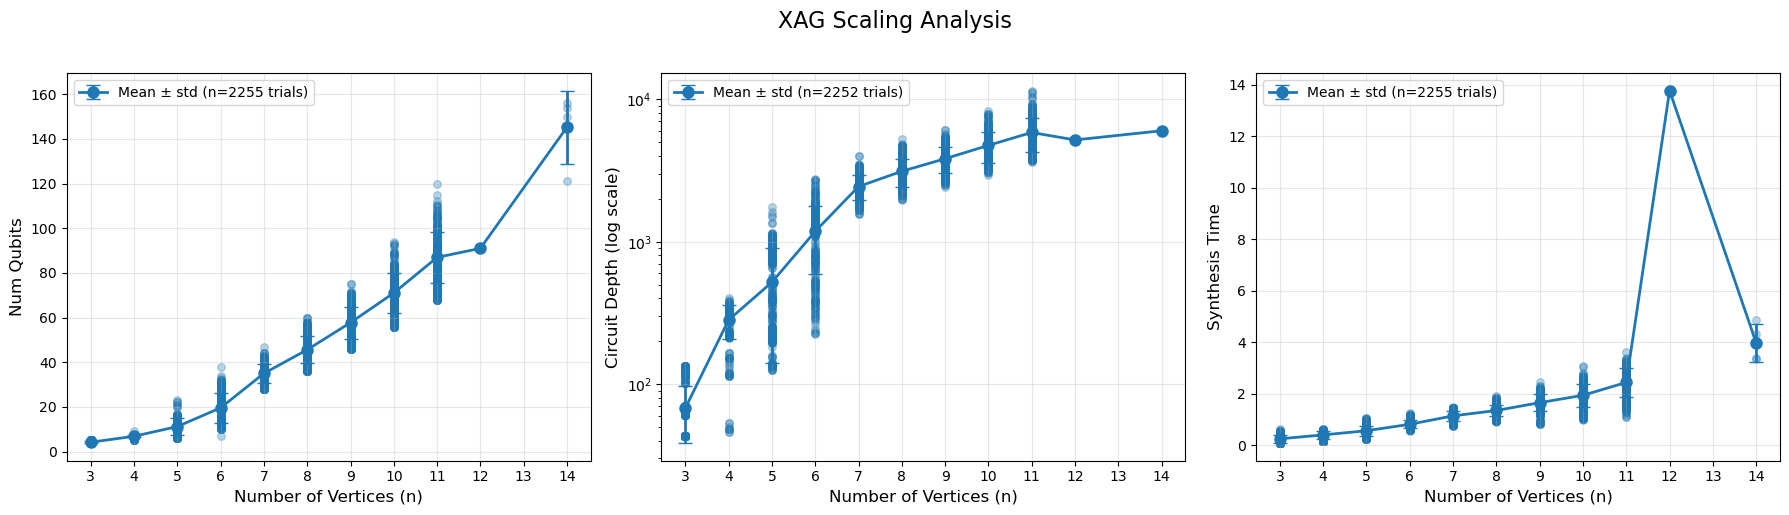

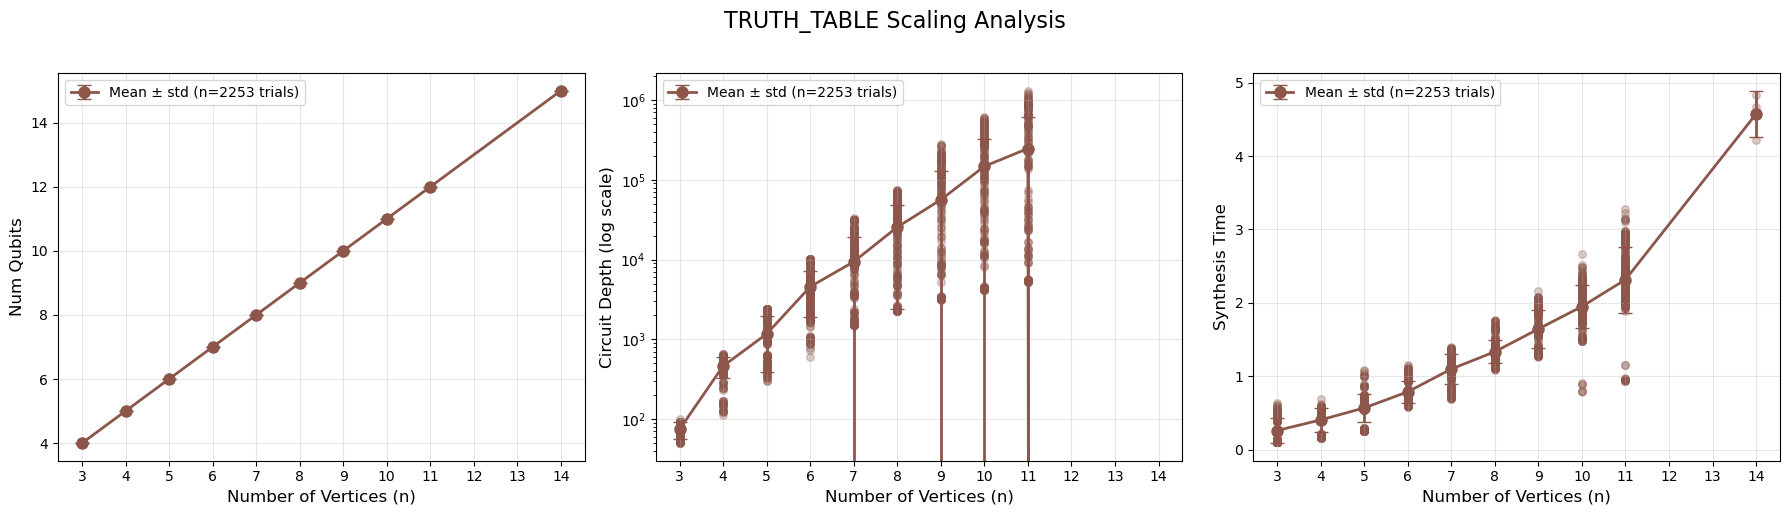

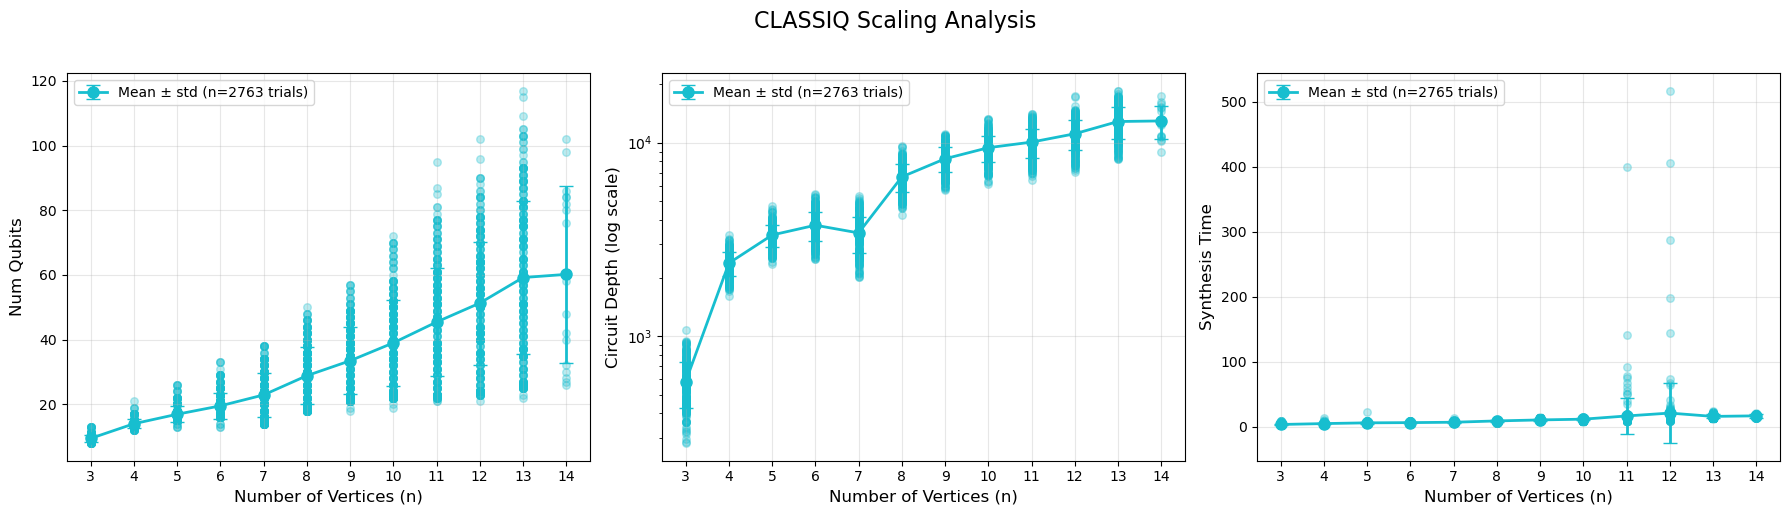

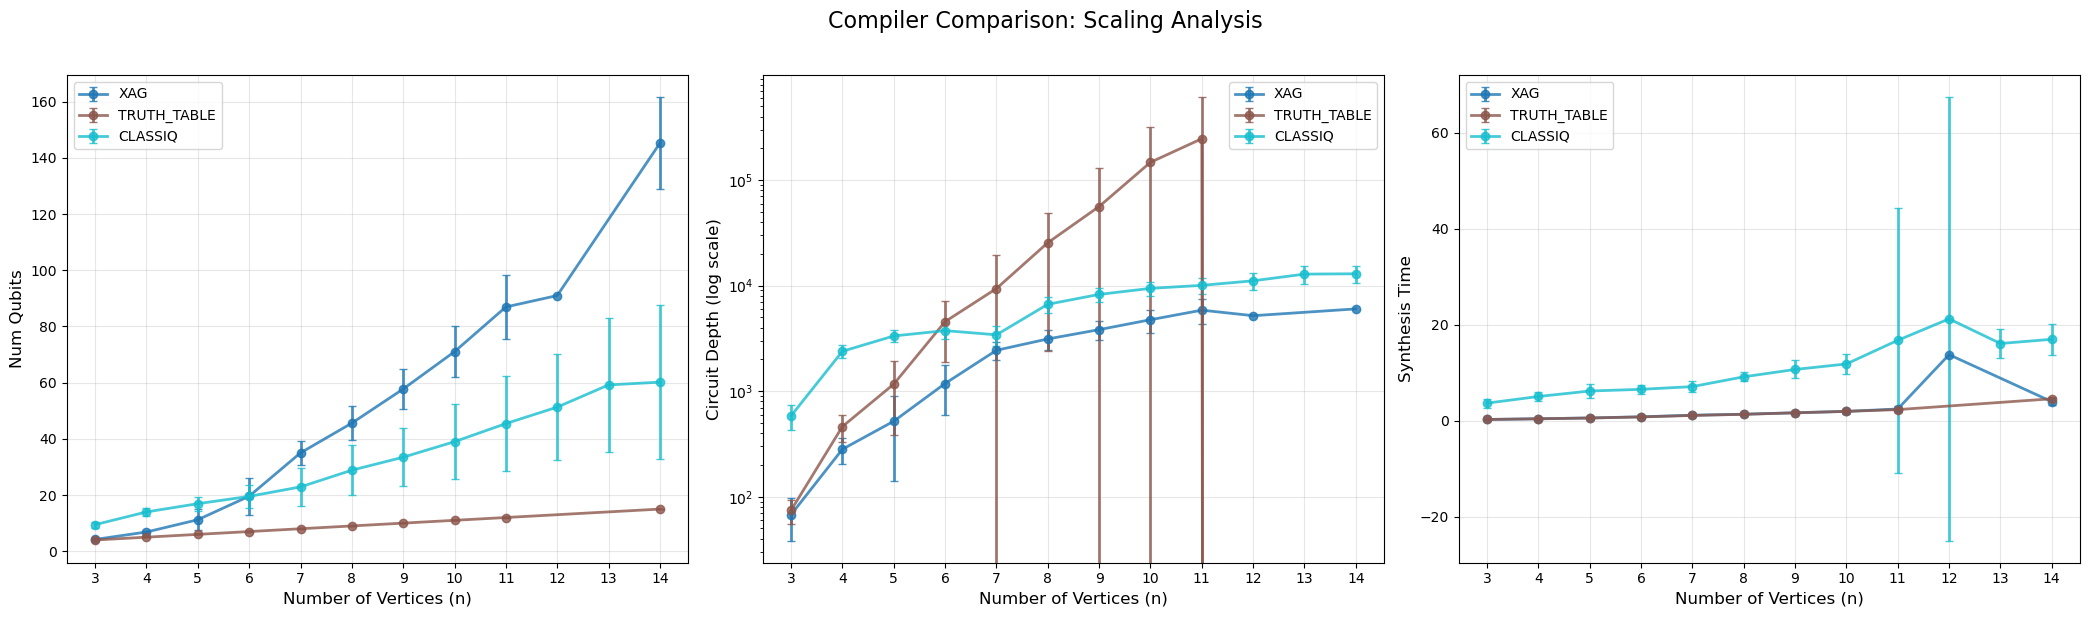

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict, Optional
from benchmarklib import BenchmarkDatabase
from benchmarklib.problems import CliqueProblem
from benchmarklib.compilers import SynthesisTrial, SynthesisCompiler, ClassiqCompiler, XAGCompiler, TruthTableCompiler
import math

def collect_synthesis_data(
    db_manager: BenchmarkDatabase,
    compilers: List[SynthesisCompiler],
    clique_size_func=lambda n: math.ceil(n / 2),
    n_range: range = range(3, 13)
) -> Dict[str, pd.DataFrame]:
    """
    Collect synthesis benchmark data from database into dataframes.
    
    Args:
        db_manager: Database containing synthesis trials
        compiler_names: List of compiler names to analyze (e.g., ["XAG_OPT", "TRUTH_TABLE"])
        clique_size_func: Function to compute clique size from n vertices
        n_range: Range of vertex counts to analyze
        
    Returns:
        Dictionary mapping compiler names to pandas DataFrames with columns:
        - n_vertices: Problem size
        - clique_size: Target clique size
        - instance_id: Problem instance ID
        - success: Whether compilation succeeded
        - synthesis_time: Compilation time
        - num_qubits: Number of qubits in circuit
        - circuit_depth: Circuit depth
        - circuit_size: Total gate count
        - cx_count: Number of CX gates (may be 0 if not transpiled)
        - single_qubit_count: Number of single-qubit gates
    """
    compiler_dataframes = {}
    
    for compiler in compilers:
        print(f"Collecting data for {compiler.name}...")
        data_rows = []
        
        # Find all trials for this compiler
        trials = db_manager.find_trials(
            job_id=f"SYNTHESIS_{compiler.name}"
        )
        
        for trial in trials:
            # Skip if not a synthesis trial
            if not isinstance(trial, SynthesisTrial):
                continue
                
            # Get problem instance to extract vertex count
            problem = db_manager.get_problem_instance(trial.instance_id)
            problem_size = problem.get_problem_size()
            n_vertices = problem_size.get("num_vertices", 0)
            
            # Skip if outside our range
            if n_vertices not in n_range:
                continue
            
            # Extract clique size from trial params
            clique_size = trial.trial_params.get("clique_size", clique_size_func(n_vertices))
            
            # Extract metrics from counts (where synthesis metrics are stored)
            if trial.counts and isinstance(trial.counts, dict):
                row = {
                    'n_vertices': n_vertices,
                    'clique_size': clique_size,
                    'instance_id': trial.instance_id,
                    'edge_probability': problem.edge_probability,
                    'success': trial.counts.get('success', False),
                    'synthesis_time': trial.counts.get('synthesis_time', np.nan),
                    'num_qubits': trial.counts.get('num_qubits', np.nan),
                    'circuit_depth': trial.counts.get('circuit_depth', np.nan),
                    'circuit_size': trial.counts.get('circuit_size', np.nan),
                    'cx_count': trial.counts.get('cx_count', 0),  # May be 0
                    'single_qubit_count': trial.counts.get('single_qubit_count', np.nan),
                }
                data_rows.append(row)
        
        # Create dataframe for this compiler
        df = pd.DataFrame(data_rows)
        if not df.empty:
            # Sort by n_vertices for better plotting
            df = df.sort_values('n_vertices')
            print(f"  Found {len(df)} trials for {compiler.name}")
        else:
            print(f"  No data found for {compiler.name}")
            
        compiler_dataframes[compiler.name] = df
    
    return compiler_dataframes


def plot_synthesis_scaling(
    compiler_dataframes: Dict[str, pd.DataFrame],
    metrics: List[str] = ['num_qubits', 'circuit_depth'],
    save_dir: Optional[str] = None,
    show_individual: bool = True,
    show_combined: bool = True,
    log_scale_depth: bool = True
):
    """
    Plot scaling behavior of synthesis compilers.
    
    Args:
        compiler_dataframes: Dict mapping compiler names to dataframes
        metrics: List of metrics to plot (from dataframe columns)
        save_dir: Directory to save plots (None for display only)
        show_individual: Whether to create individual plots per compiler
        show_combined: Whether to create combined comparison plot
        log_scale_depth: Whether to use log scale for circuit depth
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Color map for consistent colors across plots
    compiler_names = list(compiler_dataframes.keys())
    colors = plt.cm.tab10(np.linspace(0, 1, len(compiler_names)))
    color_map = dict(zip(compiler_names, colors))
    
    # ========== INDIVIDUAL PLOTS ==========
    if show_individual:
        for compiler_name, df in compiler_dataframes.items():
            if df.empty:
                print(f"Skipping {compiler_name} - no data")
                continue
                
            # Only plot successful compilations
            df_success = df[df['success'] == True].copy()
            
            if df_success.empty:
                print(f"No successful compilations for {compiler_name}")
                continue
            
            fig, axes = plt.subplots(1, len(metrics), figsize=(6*len(metrics), 5))
            if len(metrics) == 1:
                axes = [axes]
            
            fig.suptitle(f'{compiler_name} Scaling Analysis', fontsize=16, y=1.02)
            
            for ax, metric in zip(axes, metrics):
                # Group by n_vertices and calculate statistics
                grouped = df_success.groupby('n_vertices')[metric].agg(['mean', 'std', 'count'])
                
                # Plot with error bars
                x = grouped.index
                y = grouped['mean']
                yerr = grouped['std']
                
                ax.errorbar(x, y, yerr=yerr, 
                           marker='o', markersize=8, 
                           linewidth=2, capsize=5,
                           color=color_map[compiler_name],
                           label=f'Mean ± std (n={grouped["count"].sum()} trials)')
                
                # Add individual points with transparency
                ax.scatter(df_success['n_vertices'], df_success[metric], 
                          alpha=0.3, s=30, color=color_map[compiler_name])
                
                ax.set_xlabel('Number of Vertices (n)', fontsize=12)
                ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=12)
                ax.grid(True, alpha=0.3)
                ax.legend()
                
                # Use log scale for depth if requested
                if metric == 'circuit_depth' and log_scale_depth:
                    ax.set_yscale('log')
                    ax.set_ylabel('Circuit Depth (log scale)', fontsize=12)
                
                # Set integer x-ticks
                ax.set_xticks(range(df_success['n_vertices'].min(), 
                                   df_success['n_vertices'].max() + 1))
            
            plt.tight_layout()
            
            if save_dir:
                filename = f"{save_dir}/{compiler_name}_scaling.png"
                plt.savefig(filename, dpi=150, bbox_inches='tight')
                print(f"Saved: {filename}")
            plt.show()
    
    # ========== COMBINED COMPARISON PLOT ==========
    if show_combined:
        fig, axes = plt.subplots(1, len(metrics), figsize=(7*len(metrics), 6))
        if len(metrics) == 1:
            axes = [axes]
        
        fig.suptitle('Compiler Comparison: Scaling Analysis', fontsize=16, y=1.02)
        
        for ax, metric in zip(axes, metrics):
            for compiler_name, df in compiler_dataframes.items():
                if df.empty:
                    continue
                    
                # Only successful compilations
                df_success = df[df['success'] == True].copy()
                if df_success.empty:
                    continue
                
                # Group by n_vertices
                grouped = df_success.groupby('n_vertices')[metric].agg(['mean', 'std', 'count'])
                
                # Plot with error bars
                x = grouped.index
                y = grouped['mean']
                yerr = grouped['std']
                
                ax.errorbar(x, y, yerr=yerr,
                           marker='o', markersize=6,
                           linewidth=2, capsize=3,
                           color=color_map[compiler_name],
                           label=compiler_name,
                           alpha=0.8)
            
            ax.set_xlabel('Number of Vertices (n)', fontsize=12)
            ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=12)
            ax.grid(True, alpha=0.3)
            ax.legend(loc='best')
            
            # Use log scale for depth if requested
            if metric == 'circuit_depth' and log_scale_depth:
                ax.set_yscale('log')
                ax.set_ylabel('Circuit Depth (log scale)', fontsize=12)
            
            # Set integer x-ticks based on all data
            all_n = set()
            for df in compiler_dataframes.values():
                if not df.empty:
                    all_n.update(df['n_vertices'].unique())
            if all_n:
                ax.set_xticks(sorted(all_n))
        
        plt.tight_layout()
        
        if save_dir:
            filename = f"{save_dir}/compiler_comparison_scaling.png"
            plt.savefig(filename, dpi=150, bbox_inches='tight')
            print(f"Saved: {filename}")
        plt.show()


def print_scaling_summary(compiler_dataframes: Dict[str, pd.DataFrame]):
    """Print summary statistics for each compiler."""
    
    print("\n" + "="*80)
    print("SYNTHESIS SCALING SUMMARY")
    print("="*80)
    
    for compiler_name, df in compiler_dataframes.items():
        print(f"\n{compiler_name}:")
        print("-"*40)
        
        if df.empty:
            print("  No data available")
            continue
        
        # Success rate
        total_trials = len(df)
        successful = df['success'].sum()
        success_rate = successful / total_trials * 100 if total_trials > 0 else 0
        
        print(f"  Total trials: {total_trials}")
        print(f"  Success rate: {successful}/{total_trials} ({success_rate:.1f}%)")
        
        # Only analyze successful compilations
        df_success = df[df['success'] == True]
        
        if not df_success.empty:
            print(f"\n  Vertex range: {df_success['n_vertices'].min()} - {df_success['n_vertices'].max()}")
            print(f"  Unique problem instances: {df_success['instance_id'].nunique()}")
            
            # Scaling metrics
            print("\n  Average metrics by vertex count:")
            print("  n\tQubits\tDepth\tGates\tTime(s)")
            print("  " + "-"*40)
            
            for n in sorted(df_success['n_vertices'].unique()):
                n_data = df_success[df_success['n_vertices'] == n]
                print(f"  {n}\t{n_data['num_qubits'].mean():.1f}\t"
                      f"{n_data['circuit_depth'].mean():.0f}\t"
                      f"{n_data['circuit_size'].mean():.0f}\t"
                      f"{n_data['synthesis_time'].mean():.3f}")


# Example usage
def analyze_synthesis_benchmarks(db_path: str, compilers: List[SynthesisCompiler]):
    """Complete analysis workflow."""
    import math
    from benchmarklib import BenchmarkDatabase
    from benchmarklib.problems import CliqueProblem
    from benchmarklib.compilers import SynthesisTrial
    
    # Load database
    db = BenchmarkDatabase(db_path, CliqueProblem, SynthesisTrial)
    
    # Collect data
    print("Collecting synthesis benchmark data...")
    dataframes = collect_synthesis_data(
        db,
        compilers=compilers,
        clique_size_func=lambda n: math.ceil(n / 2),
        n_range=range(3, 20)
    )
    
    # Print summary
    print_scaling_summary(dataframes)
    
    # Create plots
    plot_synthesis_scaling(
        dataframes,
        metrics=['num_qubits', 'circuit_depth', 'synthesis_time'],
        show_individual=True,
        show_combined=True,
        log_scale_depth=True
    )
    
    return dataframes


# Usage example:
if __name__ == "__main__":
    # Easy to add new compilers - just extend this list
    compilers_to_analyze = [
        XAGCompiler(),
        TruthTableCompiler(),
        ClassiqCompiler(),
    ]
    
    dataframes = analyze_synthesis_benchmarks(
        "Benchmark.db",
        compilers_to_analyze
    )

# Generate Graphs

In [ ]:
from benchmarklib import BenchmarkDatabase
from benchmarklib.problems import CliqueProblem
from benchmarklib.compilers import SynthesisTrial
from typing import List
import networkx as nx

def generate_new_graphs(num_graphs_per_combo: int, nodes: List[int], edge_probabilities: List[float], db: BenchmarkDatabase): 
    """
    Given a list of graph sizes, and a list of edge probabilities, generate random graphs 
    for each combination, count the number of cliques, and add them to the database
    """
    for n in nodes:
        for ep in edge_probabilities:
            G = nx.generators.fast_gnp_random_graph(n=nodes, p=ep)
            clique_sizes = [0 for _ in range(n)]
            # for every clique count the size of it and add it to the list (index = clique size)
            for clique_list in nx.clique.enumerate_all_cliques(G):
                clique_sizes[len(clique_list)] += 1
            
            # for some reason edge probability is an int and not a float, so multiply by 100
            instance = CliqueProblem.from_nx_graph(graph=G, edge_probability=int(ep * 100), clique_counts=clique_sizes)
            print(instance)
            #id = db.save_problem_instance(instance)
            #print(f"saved problem instance: {id}")

db = BenchmarkDatabase("Benchmark.db", CliqueProblem, SynthesisTrial)
generate_new_graphs(10, nodes = [12], edge_probabilities=list(range(50, 100)), db=db)

saved problem instance: 9002
saved problem instance: 9003
saved problem instance: 9004
saved problem instance: 9005
saved problem instance: 9006
saved problem instance: 9007
saved problem instance: 9008
saved problem instance: 9009
saved problem instance: 9010
saved problem instance: 9011
saved problem instance: 9012
saved problem instance: 9013
saved problem instance: 9014
saved problem instance: 9015
saved problem instance: 9016
saved problem instance: 9017
saved problem instance: 9018
saved problem instance: 9019
saved problem instance: 9020
saved problem instance: 9021
saved problem instance: 9022
saved problem instance: 9023
saved problem instance: 9024
saved problem instance: 9025
saved problem instance: 9026
saved problem instance: 9027
saved problem instance: 9028
saved problem instance: 9029
saved problem instance: 9030
saved problem instance: 9031
saved problem instance: 9032
saved problem instance: 9033
saved problem instance: 9034
saved problem instance: 9035
saved problem 